In [401]:
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randrange

In [477]:
class Player:
    def __init__(self, inherentRating, gamesPlayed=0):
        self.inherentRating = inherentRating
        self.gamesPlayed = gamesPlayed
        self.elo = 1400.0
        self.priors = []

    def __str__(self):
        return "Inherent rating: " + str(self.inherentRating) + " ELO: " + str(self.elo) + " GP: " + str(self.gamesPlayed) + " Priors: " + str(len(self.priors))

    def setElo(self, newElo):
        self.elo = newElo

    def incrementGP(self):
        self.gamesPlayed += 1
    
    # The following function was used for an alternative approach to benchmarking and was not discussed in the paper
    def addPrior(self, opponent):
        self.priors.append(opponent)



In [478]:
class Simulation:
    def __init__(self, players, clusters):
        self.players = players
        self.k = 1
        self.clusters = clusters
    
    def returnDist(self):
        dist = []
        for player in self.players:
            dist.append(player.elo)
        return dist
    
    def calculateExpectedOutcome(self, a, b):
        return 1 / (1 + 10**( (b.elo-a.elo) / 400))
    
    def simulateGame(self, a, b, k):
        a.incrementGP()
        b.incrementGP()
        
        a_expected, b_expected = self.calculateExpectedOutcome(a, b), self.calculateExpectedOutcome(b, a)
        if a == self.determineWinner(a, b):
            a.setElo(a.elo + k * (1 - a_expected))
            b.setElo(b.elo + k * (0 - b_expected))
            a.addPrior((b, self.k*(0-b_expected)))
            return b, k*(0-b_expected) # returns loser for use with benchmarking
        else:
            a.setElo(a.elo + k * (0 - a_expected))
            b.setElo(b.elo + k * (1 - b_expected))
            b.addPrior((a, k*(0-a_expected)))
            return a, k*(0-a_expected)
    
    # The following function was used for an alternative approach to benchmarking and was not discussed in the paper
    def simulateGameBench(self, a, b):
        print('simulating between ' + str(a.elo) + ' and ' + str(b.elo))
        a.incrementGP()
        b.incrementGP()
        
        a_expected, b_expected = self.calculateExpectedOutcome(a, b), self.calculateExpectedOutcome(b, a)
        if a == self.determineWinner(a, b):
            a.setElo(a.elo + self.k * (1 - a_expected))
            b.setElo(b.elo + self.k * (0 - b_expected))
            a.addPrior((b, self.k*(0-b_expected)))
            print('a wins, b expected: ', self.k*(0-b_expected))
            return b, self.k*(0-b_expected) # returns loser for use with benchmarking
        else:
            a.setElo(a.elo + self.k * (0 - a_expected))
            b.setElo(b.elo + self.k * (1 - b_expected))
            b.addPrior((a, self.k*(0-a_expected)))
            print('b wins, a expected: ', self.k*(0-a_expected))
            return a, self.k*(0-a_expected)
    
    # The following function was used for an alternative approach to benchmarking and was not discussed in the paper
    def adjustPriors(self, loser):
        for player in loser[0].priors:
            player[0].setElo(player[0].elo + loser[1])
            
    
    def determineWinner(self, a, b):
        diff = a.inherentRating - b.inherentRating
        percentage = 1 / (1 + 50**(diff/60))
        if random.uniform(0.0, 1.0) < percentage:
            return b
        return a
    
    def chooseOpponent(self, index):
        opponentIndex = randrange(0, len(self.players))
        if opponentIndex == index:
            return self.chooseOpponent(index)
        return opponentIndex
    
    def simulate(self, steps, k):
        for i in range(len(self.players)):
            for numgames in range(steps):
                if(len(self.players) < 2):
                    break
                self.simulateGame(self.players[i], self.players[self.chooseOpponent(i)], k)
    
    def printPlayers(self):
        for player in self.players:
            print(player)
    
    # The following function was used for an alternative approach to benchmarking and was not discussed in the paper
    def benchmarkClusters(self, numGames):
        if not self.clusters or len(self.clusters) < 2:
            return None
        
        for i in range(numGames):
            primaryIndex = randrange(0, len(self.clusters[0]))
            opponentIndex = randrange(0, len(self.clusters[1]))
            print('benchmarking between', self.clusters[0][primaryIndex].elo, ' and', self.clusters[1][opponentIndex])
            self.adjustPriors(self.simulateGameBench(self.clusters[0][primaryIndex], self.clusters[1][opponentIndex]))


In [479]:
# Used to calculate the Z score of a player based on the distribution they belong in

def calculateZScore(score, dist):
    return (score - np.mean(dist))/np.std(dist)

In [480]:
# Used to calculate the mean difference in Z score between the inherent rating distribution and the Elo rating
# A lower eloAccuracy score implies that the Elo distribution more closely resembles the inherent rating distribution
# and thus the Elo ratings for the players offers a good representation of skill

# Remember that the inherent rating, in the real world, is not something that can be quantitatively measured. This is
# why the inherent rating is hidden from the Elo aspect of the model, and the intention of the experiment is to 
# produce an Elo distribution that as closely resembles the inherent rating distribution as possible

def eloAccuracy(players_list, sim_dist, ir_dist):
    average_error = 0.0
    for player in players_list:
        average_error += abs(calculateZScore(player.elo, sim_dist) - calculateZScore(player.inherentRating, ir_dist))
    return average_error / len(players_list)

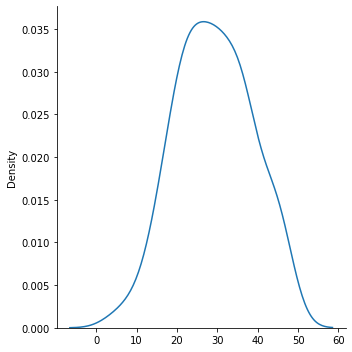

In [529]:
# Setting up normal distribution for inherent rating

p_cluster_driver = random.normal(loc=30, scale=10, size=100)
p_cluster_driver.sort()
sns.displot(p_cluster_driver, kind='kde')
plt.show()

Control Elo distribution:


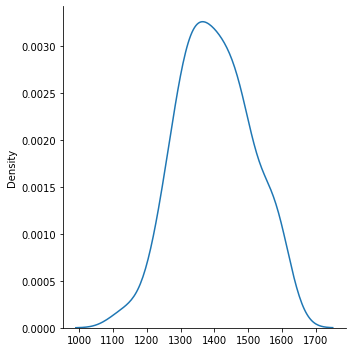

Control Elo mean error: 
0.06485326993328112


In [530]:
# Setting up control simulation (no clusters)

control_dist = []
for value in p_cluster_driver:
    control_dist.append(value)

control_players = []
control_ir = []

for i in range(len(control_dist)):
    control_players.append(Player(control_dist[i], 0))
    control_ir.append(control_dist[i])
    
control_sim = Simulation(control_players, None)
control_sim.simulate(10000, 1)
control_dist = control_sim.returnDist()
print("Control Elo distribution:")
sns.displot(control_dist, kind='kde')
plt.show()

print("Control Elo mean error: ")
print(eloAccuracy(control_players, control_dist, control_ir))

In [531]:
print(np.std(control_dist))

107.1448986916511


In [532]:
p_cluster_players = []
p_cluster_ir = []
for i in range(len(p_cluster_driver)):
    p_cluster_players.append(Player(p_cluster_driver[i], 0))
    p_cluster_ir.append(p_cluster_driver[i])

In [533]:
# Splits players into clusters of a given size

def clusterify(players, size):
    clusters = []
    num_clusters = 0
    count = 0
    while count + size*num_clusters < len(players):
        if count == 0:
            clusters.append([])
        
        clusters[num_clusters].append(players[count + size*num_clusters])
        count += 1
        
        if count == size:
            count = 0
            num_clusters += 1
    
    return clusters

clusters = clusterify(p_cluster_players, 50)

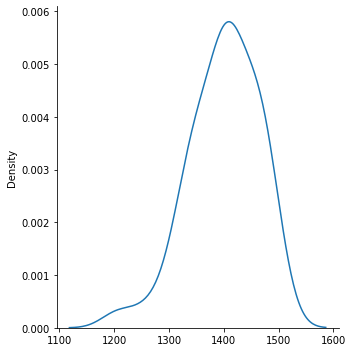

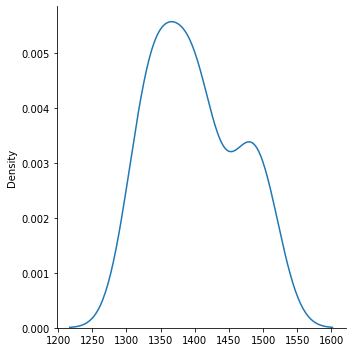

In [534]:
# Runs separate simulations on each cluster

def simulate_clusters(clustery, steps, k):
    simulations = []
    distributions = []
    for cluster in clustery:
        simulations.append(Simulation(cluster, None))
    
    for simulation in simulations:
        simulation.simulate(steps, k)
        distributions.append(simulation.returnDist())
    
    return simulations, distributions

cluster_sims, cluster_dists = simulate_clusters(clusters, 10000, 1)

for dist in cluster_dists:
    sns.displot(dist, kind='kde')

plt.show()

In [535]:
# Recombines clusters and tests accuracy compared to the control - yikes!

cluster_dist_combined = []
for player in p_cluster_players:
    cluster_dist_combined.append(player.elo)

print(eloAccuracy(p_cluster_players, cluster_dist_combined, p_cluster_ir))

0.8396303129913505


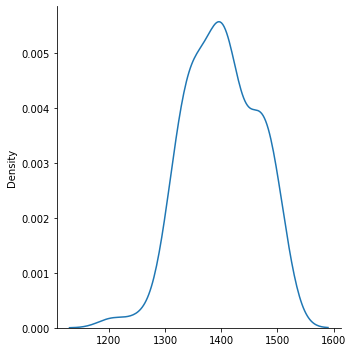

In [536]:
sns.displot(cluster_dist_combined, kind='kde')

plt.show()

In [547]:
print(np.std(cluster_dist_combined))

62.546376969622585


In [538]:
# Discretizes clusters based on standard deviation

def discretizeClusters(clusters):
    discretized_clusters = []
    for count, cluster in enumerate(clusters):
        discretized_clusters.append([[], [], [], [], [], []])
        for player in cluster:
            if calculateZScore(player.elo, cluster_dists[count]) < -2:
                discretized_clusters[count][0].append(player)
            elif calculateZScore(player.elo, cluster_dists[count]) < -1:
                discretized_clusters[count][1].append(player)
            elif calculateZScore(player.elo, cluster_dists[count]) < 0:
                discretized_clusters[count][2].append(player)
            elif calculateZScore(player.elo, cluster_dists[count]) < 1:
                discretized_clusters[count][3].append(player)
            elif calculateZScore(player.elo, cluster_dists[count]) < 2:
                discretized_clusters[count][4].append(player)
            else: 
                discretized_clusters[count][5].append(player)
    
    return discretized_clusters

discretized_clusters = discretizeClusters(clusters)

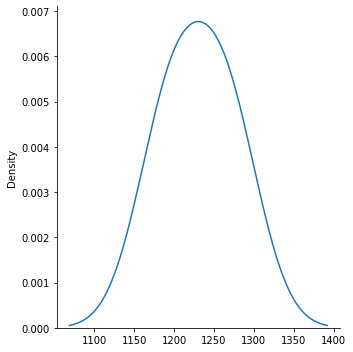

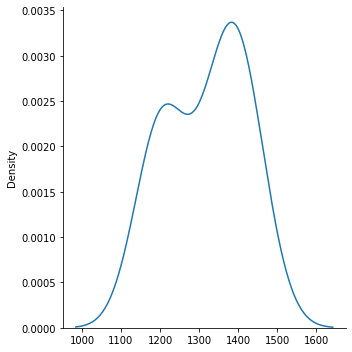

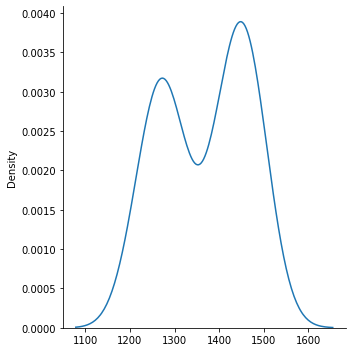

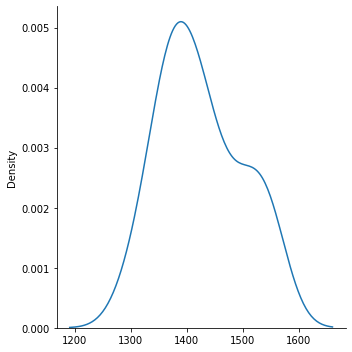

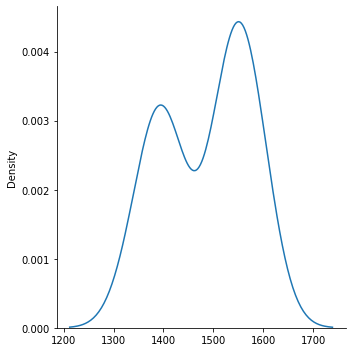

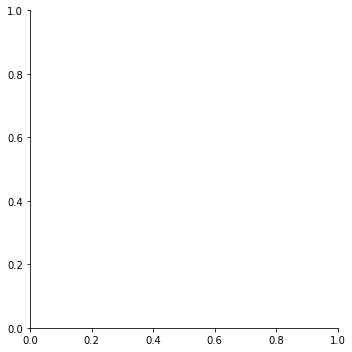

In [539]:
# Groups players within respective standard deviations across clusters into a new cluster

def deviation_group(discretized_clusters):
    grouped = []
    for deviation in range(6):
        grouped.append([])
        for i in range(len(discretized_clusters)):
            for player in discretized_clusters[i][deviation]:
                grouped[deviation].append(player)
    
    return grouped

# Simulates new clusters

deviation_groups = deviation_group(discretized_clusters)
dev_cluster_sims, dev_cluster_dists = simulate_clusters(deviation_groups, 100, 10)

for dist in dev_cluster_dists:
    sns.displot(dist, kind='kde')

plt.show()

0.2780415657722191


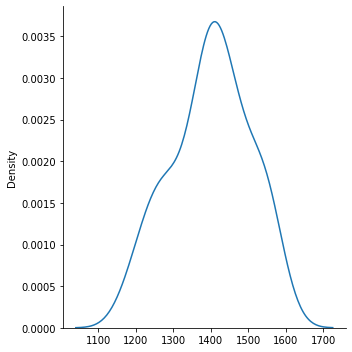

In [546]:
# Recombines discretized clusters and tests accuracy compared to the control - much better!

dev_cluster_dist_combined = []
for player in p_cluster_players:
    dev_cluster_dist_combined.append(player.elo)


print(eloAccuracy(p_cluster_players, dev_cluster_dist_combined, p_cluster_ir))
sns.displot(dev_cluster_dist_combined, kind='kde')
plt.show()

In [545]:
print(np.std(dev_cluster_dist_combined))

104.38613890132149


### The following cells were used for testing alternative hypotheses for cluster benchmarking. These are a work in progress and were not discussed in my paper

In [294]:
for player in p_cluster_players:
    print(player)
bench_sim = Simulation(p_cluster_players, clusters)

Inherent rating: 10.363772622825241 ELO: 1234.013192064224 GP: 20088 Priors: 6292
Inherent rating: 12.174183116973044 ELO: 1281.5042756875273 GP: 20144 Priors: 6566
Inherent rating: 15.694884265909474 ELO: 1307.8578960460238 GP: 20017 Priors: 7706
Inherent rating: 16.544094815798502 ELO: 1331.0133866414972 GP: 20253 Priors: 7968
Inherent rating: 16.589105332512887 ELO: 1332.402277838974 GP: 20044 Priors: 8072
Inherent rating: 16.655162068691023 ELO: 1333.0156227886966 GP: 19847 Priors: 7924
Inherent rating: 16.743858562429864 ELO: 1324.1832835210528 GP: 19996 Priors: 7840
Inherent rating: 17.142306679075602 ELO: 1339.4717686341219 GP: 19974 Priors: 8055
Inherent rating: 18.49858429137373 ELO: 1344.5834625809953 GP: 19908 Priors: 8609
Inherent rating: 18.87815386054708 ELO: 1359.2983656536658 GP: 19997 Priors: 8554
Inherent rating: 19.076748487035502 ELO: 1348.7453313115504 GP: 19903 Priors: 8731
Inherent rating: 20.259908354778414 ELO: 1371.0193256154434 GP: 19979 Priors: 9083
Inherent

In [295]:
bench_sim.benchmarkClusters(1000)

benchmarking between 1332.402277838974  and Inherent rating: 41.63607105180441 ELO: 1448.4535777103495 GP: 20000 Priors: 10947
simulating between 1332.402277838974 and 1448.4535777103495
b wins, a expected:  -0.3389347399857815
benchmarking between 1401.9156130068995  and Inherent rating: 41.68184272702371 ELO: 1420.95959464824 GP: 20027 Priors: 10911
simulating between 1401.9156130068995 and 1420.95959464824
b wins, a expected:  -0.4726209216728531
benchmarking between 1212.7759557022503  and Inherent rating: 33.2812280975876 ELO: 1351.6030522052392 GP: 20072 Priors: 8338
simulating between 1212.7759557022503 and 1351.6030522052392
b wins, a expected:  -0.3102067279753638
benchmarking between 1288.941958505516  and Inherent rating: 34.934937010937325 ELO: 1347.232295492892 GP: 20192 Priors: 8934
simulating between 1288.941958505516 and 1347.232295492892
b wins, a expected:  -0.4168917739057674
benchmarking between 1105.3245630805054  and Inherent rating: 30.531405926365434 ELO: 1314.4

benchmarking between -1573.0653802361892  and Inherent rating: 35.60504273810363 ELO: -1311.1886625768032 GP: 20082 Priors: 9142
simulating between -1573.0653802361892 and -1311.1886625768032
a wins, b expected:  -0.8186879719494559
benchmarking between -1060.6463709775235  and Inherent rating: 46.25884155505161 ELO: -391.7840756306321 GP: 19992 Priors: 12318
simulating between -1060.6463709775235 and -391.7840756306321
b wins, a expected:  -0.020830614797273963
benchmarking between -1017.4132308312622  and Inherent rating: 32.92912258049995 ELO: -1552.083480401637 GP: 20044 Priors: 8208
simulating between -1017.4132308312622 and -1552.083480401637
b wins, a expected:  -0.9559680660207289
benchmarking between -2028.3961647611563  and Inherent rating: 41.72482429799623 ELO: -636.0668466034039 GP: 19793 Priors: 10904
simulating between -2028.3961647611563 and -636.0668466034039
b wins, a expected:  -0.000330394791487282
benchmarking between -1784.0480455836107  and Inherent rating: 33.28

a wins, b expected:  -0.9813057229555178
benchmarking between -4563.215076147538  and Inherent rating: 43.31152954940864 ELO: -2247.4864444189607 GP: 19956 Priors: 11462
simulating between -4563.215076147538 and -2247.4864444189607
a wins, b expected:  -0.999998375657097
benchmarking between -3742.8343662862812  and Inherent rating: 34.923157213597285 ELO: -3950.9607281045346 GP: 20009 Priors: 8900
simulating between -3742.8343662862812 and -3950.9607281045346
a wins, b expected:  -0.23181843767156077
benchmarking between -6115.113680592505  and Inherent rating: 41.68184272702371 ELO: -3020.0565936867038 GP: 20029 Priors: 10913
simulating between -6115.113680592505 and -3020.0565936867038
b wins, a expected:  -1.8296047317957546e-08
benchmarking between -3545.3807638834496  and Inherent rating: 34.923157213597285 ELO: -3951.192546542206 GP: 20010 Priors: 8900
simulating between -3545.3807638834496 and -3951.192546542206
b wins, a expected:  -0.9118182295647277
benchmarking between -506

benchmarking between -6360.319431759031  and Inherent rating: 46.97095625182591 ELO: -4150.841083273311 GP: 20174 Priors: 12835
simulating between -6360.319431759031 and -4150.841083273311
b wins, a expected:  -2.9943518345922036e-06
benchmarking between -5915.8400072858885  and Inherent rating: 35.60504273810363 ELO: -6953.264212297919 GP: 20087 Priors: 9144
simulating between -5915.8400072858885 and -6953.264212297919
b wins, a expected:  -0.9974570741171931
benchmarking between -8656.02731791303  and Inherent rating: 49.5615085677029 ELO: -3808.6860610469425 GP: 19943 Priors: 13244
simulating between -8656.02731791303 and -3808.6860610469425
b wins, a expected:  -7.61459585059702e-13
benchmarking between -4894.485073851475  and Inherent rating: 33.12029329155392 ELO: -7141.195325341468 GP: 19872 Priors: 8386
simulating between -4894.485073851475 and -7141.195325341468
a wins, b expected:  -2.416703225467556e-06
benchmarking between -6737.689997479643  and Inherent rating: 37.1618016

benchmarking between -8070.103875238066  and Inherent rating: 30.531405926365434 ELO: -11057.075104887173 GP: 19963 Priors: 7580
simulating between -8070.103875238066 and -11057.075104887173
b wins, a expected:  -0.9999999659143239
benchmarking between -10647.320255142358  and Inherent rating: 34.923157213597285 ELO: -9760.153021711047 GP: 20015 Priors: 8905
simulating between -10647.320255142358 and -9760.153021711047
b wins, a expected:  -0.00601811367232547
benchmarking between -8348.770704890705  and Inherent rating: 35.60504273810363 ELO: -9839.589296460661 GP: 20088 Priors: 9145
simulating between -8348.770704890705 and -9839.589296460661
a wins, b expected:  -0.00018744424344277895
benchmarking between -10551.593335125397  and Inherent rating: 40.564402117081954 ELO: -7200.76089507193 GP: 20129 Priors: 10832
simulating between -10551.593335125397 and -7200.76089507193
a wins, b expected:  -0.999999995803194
benchmarking between -7671.692460655235  and Inherent rating: 31.7633439

benchmarking between -15086.80888917057  and Inherent rating: 30.531405926365434 ELO: -13267.388393463238 GP: 19965 Priors: 7581
simulating between -15086.80888917057 and -13267.388393463238
b wins, a expected:  -2.827720497325477e-05
benchmarking between -11222.696482017433  and Inherent rating: 41.68184272702371 ELO: -9569.954735513751 GP: 20031 Priors: 10915
simulating between -11222.696482017433 and -9569.954735513751
b wins, a expected:  -7.380972332846551e-05
benchmarking between -14210.875100652285  and Inherent rating: 31.763343906821863 ELO: -13267.455920289593 GP: 20054 Priors: 7864
simulating between -14210.875100652285 and -13267.455920289593
b wins, a expected:  -0.004360678706679134
benchmarking between -12325.98510051462  and Inherent rating: 44.91797650886027 ELO: -8346.879175556105 GP: 19971 Priors: 11992
simulating between -12325.98510051462 and -8346.879175556105
b wins, a expected:  -1.1278080432753568e-10
benchmarking between -12106.535715279255  and Inherent ratin

benchmarking between -21793.82867737085  and Inherent rating: 39.82660613723957 ELO: -11344.162097103932 GP: 19860 Priors: 10327
simulating between -21793.82867737085 and -11344.162097103932
b wins, a expected:  -7.513348770950388e-27
benchmarking between -16652.626984993338  and Inherent rating: 44.956649105745925 ELO: -9452.762848757786 GP: 19956 Priors: 11943
simulating between -16652.626984993338 and -9452.762848757786
b wins, a expected:  -1.0007824006125476e-18
benchmarking between -18781.75825233503  and Inherent rating: 41.72482429799623 ELO: -10755.34924536844 GP: 19806 Priors: 10916
simulating between -18781.75825233503 and -10755.34924536844
b wins, a expected:  -8.589689842971464e-21
benchmarking between -19852.843459176747  and Inherent rating: 30.09521528643408 ELO: -15719.271219302247 GP: 19783 Priors: 7208
simulating between -19852.843459176747 and -15719.271219302247
b wins, a expected:  -4.635209845094715e-11
benchmarking between -15748.333607148657  and Inherent rati

benchmarking between -18622.650602793812  and Inherent rating: 33.050954526155465 ELO: -16818.17744428903 GP: 20008 Priors: 8266
simulating between -18622.650602793812 and -16818.17744428903
b wins, a expected:  -3.081794810188913e-05
benchmarking between -16917.729206735665  and Inherent rating: 30.531405926365434 ELO: -17128.849008894944 GP: 19967 Priors: 7583
simulating between -16917.729206735665 and -17128.849008894944
a wins, b expected:  -0.2287640432285336
benchmarking between -17519.408391199544  and Inherent rating: 33.2812280975876 ELO: -16541.76090137259 GP: 20076 Priors: 8341
simulating between -17519.408391199544 and -16541.76090137259
b wins, a expected:  -0.0035836214962694703
benchmarking between -19036.986952236584  and Inherent rating: 30.09521528643408 ELO: -17602.25801002183 GP: 19787 Priors: 7212
simulating between -19036.986952236584 and -17602.25801002183
b wins, a expected:  -0.00025886015588734966
benchmarking between -13403.274332647194  and Inherent rating: 

benchmarking between -16626.61458271584  and Inherent rating: 30.531405926365434 ELO: -20178.99083358057 GP: 19968 Priors: 7583
simulating between -16626.61458271584 and -20178.99083358057
a wins, b expected:  -1.315404648471175e-09
benchmarking between -17194.614770349515  and Inherent rating: 30.531405926365434 ELO: -20178.990833581887 GP: 19969 Priors: 7583
simulating between -17194.614770349515 and -20178.990833581887
a wins, b expected:  -3.459870365107753e-08
benchmarking between -18971.806002483358  and Inherent rating: 41.72482429799623 ELO: -14304.890115919428 GP: 19812 Priors: 10922
simulating between -18971.806002483358 and -14304.890115919428
a wins, b expected:  -0.9999999999978486
benchmarking between -27260.92497378022  and Inherent rating: 33.12029329155392 ELO: -18747.367478235225 GP: 19876 Priors: 8388
simulating between -27260.92497378022 and -18747.367478235225
b wins, a expected:  -5.201232422821016e-22
benchmarking between -22146.693626616245  and Inherent rating:

b wins, a expected:  -0.4140025923688415
benchmarking between -21255.070146673424  and Inherent rating: 33.43691281507224 ELO: -21867.10302578689 GP: 19961 Priors: 8346
simulating between -21255.070146673424 and -21867.10302578689
a wins, b expected:  -0.02866082624489
benchmarking between -20078.033171771935  and Inherent rating: 32.10004335324642 ELO: -22514.88196008132 GP: 20100 Priors: 7965
simulating between -20078.033171771935 and -22514.88196008132
b wins, a expected:  -0.9999991911319562
benchmarking between -24187.440097087852  and Inherent rating: 40.564402117081954 ELO: -15486.378215197301 GP: 20135 Priors: 10834
simulating between -24187.440097087852 and -15486.378215197301
a wins, b expected:  -1.0
benchmarking between -21002.03731239037  and Inherent rating: 41.68184272702371 ELO: -16806.352165589124 GP: 20036 Priors: 10919
simulating between -21002.03731239037 and -16806.352165589124
b wins, a expected:  -3.2418068304909306e-11
benchmarking between -16750.240435064192  a

benchmarking between -24567.504527249726  and Inherent rating: 37.37299822908687 ELO: -21663.74313783014 GP: 20186 Priors: 9720
simulating between -24567.504527249726 and -21663.74313783014
b wins, a expected:  -5.502961856759518e-08
benchmarking between -20016.40211717197  and Inherent rating: 47.0818221690099 ELO: -14597.21589505369 GP: 20098 Priors: 12669
simulating between -20016.40211717197 and -14597.21589505369
a wins, b expected:  -0.9999999999999716
benchmarking between -28851.170218306943  and Inherent rating: 50.603596699526534 ELO: -12788.231401329767 GP: 20051 Priors: 13639
simulating between -28851.170218306943 and -12788.231401329767
b wins, a expected:  -6.960700658736772e-41
benchmarking between -20955.566063441696  and Inherent rating: 40.564402117081954 ELO: -17235.829485677492 GP: 20137 Priors: 10834
simulating between -20955.566063441696 and -17235.829485677492
a wins, b expected:  -0.9999999994980522
benchmarking between -17387.50892894761  and Inherent rating: 56

benchmarking between -33404.21358901484  and Inherent rating: 49.311986765579405 ELO: -14673.526384151668 GP: 20116 Priors: 13274
simulating between -33404.21358901484 and -14673.526384151668
b wins, a expected:  -1.4903284353695037e-47
benchmarking between -30832.48248001131  and Inherent rating: 33.734252381579665 ELO: -25854.686586991043 GP: 20009 Priors: 8446
simulating between -30832.48248001131 and -25854.686586991043
b wins, a expected:  -3.593438921466304e-13
benchmarking between -31524.36068103872  and Inherent rating: 50.603596699526534 ELO: -14367.916600508399 GP: 20053 Priors: 13641
simulating between -31524.36068103872 and -14367.916600508399
b wins, a expected:  -1.2849605624891794e-43
benchmarking between -21847.125608206316  and Inherent rating: 33.734252381579665 ELO: -25854.686586991043 GP: 20010 Priors: 8447
simulating between -21847.125608206316 and -25854.686586991043
b wins, a expected:  -0.999999999904259
benchmarking between -20451.29377660152  and Inherent rati

benchmarking between -24986.742057722997  and Inherent rating: 36.061445063893615 ELO: -25578.662845167364 GP: 19920 Priors: 9224
simulating between -24986.742057722997 and -25578.662845167364
a wins, b expected:  -0.0320659277087795
benchmarking between -32901.10916624968  and Inherent rating: 33.12029329155392 ELO: -28437.405718677895 GP: 19882 Priors: 8392
simulating between -32901.10916624968 and -28437.405718677895
b wins, a expected:  -6.9301299935183546e-12
benchmarking between -31138.403514853097  and Inherent rating: 41.72482429799623 ELO: -21802.177792725233 GP: 19817 Priors: 10925
simulating between -31138.403514853097 and -21802.177792725233
a wins, b expected:  -1.0
benchmarking between -31545.246647609783  and Inherent rating: 43.31152954940864 ELO: -20639.919358283325 GP: 19964 Priors: 11465
simulating between -31545.246647609783 and -20639.919358283325
b wins, a expected:  -5.453581109886675e-28
benchmarking between -25848.229660534726  and Inherent rating: 49.311986765

benchmarking between -35701.014832232206  and Inherent rating: 41.63607105180441 ELO: -24451.41954518258 GP: 20016 Priors: 10959
simulating between -35701.014832232206 and -24451.41954518258
b wins, a expected:  -7.516432857662012e-29
benchmarking between -38646.30928000691  and Inherent rating: 56.948783712321145 ELO: -12813.032500424693 GP: 19994 Priors: 15169
simulating between -38646.30928000691 and -12813.032500424693
b wins, a expected:  -2.6110070895478446e-65
benchmarking between -28144.989104578846  and Inherent rating: 31.633631008002375 ELO: -34204.157673883674 GP: 20029 Priors: 7752
simulating between -28144.989104578846 and -34204.157673883674
a wins, b expected:  -7.113422048896219e-16
benchmarking between -28144.989104578846  and Inherent rating: 39.4472487820738 ELO: -26665.72804840058 GP: 19904 Priors: 10160
simulating between -28144.989104578846 and -26665.72804840058
a wins, b expected:  -0.9997996633783887
benchmarking between -34354.44730506919  and Inherent rating

benchmarking between -41432.51724546717  and Inherent rating: 49.311986765579405 ELO: -19585.075922806333 GP: 20120 Priors: 13276
simulating between -41432.51724546717 and -19585.075922806333
b wins, a expected:  -2.4065599968602846e-55
benchmarking between -34955.83929130762  and Inherent rating: 32.10004335324642 ELO: -36959.02591363676 GP: 20105 Priors: 7970
simulating between -34955.83929130762 and -36959.02591363676
a wins, b expected:  -9.818139087590686e-06
benchmarking between -45041.968562085334  and Inherent rating: 32.92912258049995 ELO: -35540.71757151518 GP: 20059 Priors: 8219
simulating between -45041.968562085334 and -35540.71757151518
a wins, b expected:  -1.0
benchmarking between -37052.2588245522  and Inherent rating: 44.91797650886027 ELO: -24312.851627719156 GP: 19980 Priors: 11999
simulating between -37052.2588245522 and -24312.851627719156
b wins, a expected:  -1.417365991161284e-32
benchmarking between -26127.506148972538  and Inherent rating: 32.92912258049995 E

benchmarking between -42219.78555116671  and Inherent rating: 37.967801172828125 ELO: -31968.02829231105 GP: 20177 Priors: 9840
simulating between -42219.78555116671 and -31968.02829231105
b wins, a expected:  -2.347506767050733e-26
benchmarking between -31247.625718830288  and Inherent rating: 33.12029329155392 ELO: -36264.67569330299 GP: 19885 Priors: 8395
simulating between -31247.625718830288 and -36264.67569330299
a wins, b expected:  -2.8666525892564546e-13
benchmarking between -31264.311590008663  and Inherent rating: 30.531405926365434 ELO: -39315.69545210589 GP: 19981 Priors: 7590
simulating between -31264.311590008663 and -39315.69545210589
b wins, a expected:  -1.0
benchmarking between -35354.88366404765  and Inherent rating: 33.734252381579665 ELO: -35993.468574582854 GP: 20017 Priors: 8453
simulating between -35354.88366404765 and -35993.468574582854
b wins, a expected:  -0.9753011651221639
benchmarking between -36152.533476466415  and Inherent rating: 43.31152954940864 EL

benchmarking between -32815.69692316556  and Inherent rating: 37.54596608411001 ELO: -34561.84565902478 GP: 20001 Priors: 9794
simulating between -32815.69692316556 and -34561.84565902478
b wins, a expected:  -0.9999568868816631
benchmarking between -35172.900736720236  and Inherent rating: 32.10004335324642 ELO: -41362.05876812677 GP: 20106 Priors: 7970
simulating between -35172.900736720236 and -41362.05876812677
a wins, b expected:  -3.365928772435353e-16
benchmarking between -53407.749534520466  and Inherent rating: 33.43691281507224 ELO: -39787.4012983 GP: 19970 Priors: 8351
simulating between -53407.749534520466 and -39787.4012983
b wins, a expected:  -8.894661181682834e-35
benchmarking between -33775.574933911754  and Inherent rating: 40.912208742927305 ELO: -31780.770391123217 GP: 20076 Priors: 10735
simulating between -33775.574933911754 and -31780.770391123217
b wins, a expected:  -1.030348559501094e-05
benchmarking between -30959.635844799806  and Inherent rating: 32.0288630

0.4449793044106296


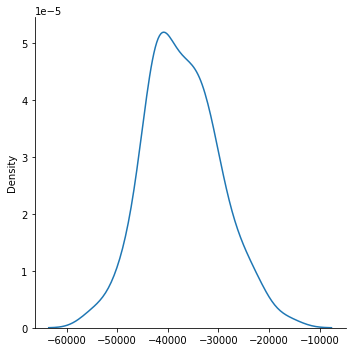

In [296]:
cluster_dist_combined = []
for player in p_cluster_players:
    cluster_dist_combined.append(player.elo)


print(eloAccuracy(p_cluster_players, cluster_dist_combined, p_cluster_ir))
sns.displot(cluster_dist_combined, kind='kde')
plt.show()